In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
import warnings

warnings.filterwarnings('ignore')

In [21]:
data = pd.read_csv('data/train.csv')
df_immo = data.copy()
# robustscaler 

In [22]:
# titre des colonnes en minuscule
df_immo.columns = [x.lower() for x in df_immo.columns]
df_immo.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


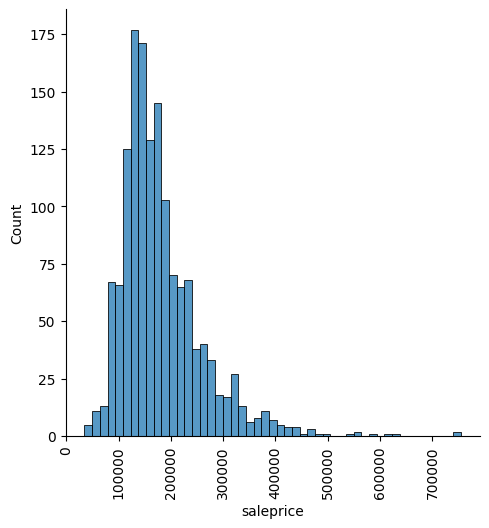

In [23]:
# histogramme de la repartition des prix 
sns.displot(df_immo['saleprice']) 
plt.xticks(rotation=90)
plt.show()

In [24]:
# nombre de valeurs nulles par colonnes
df_immo.isnull().sum()

id                 0
mssubclass         0
mszoning           0
lotfrontage      259
lotarea            0
                ... 
mosold             0
yrsold             0
saletype           0
salecondition      0
saleprice          0
Length: 81, dtype: int64

In [25]:
# seulement les colonnes avec des valeurs nulles
features_with_na=[features for features in df_immo.columns if df_immo[features].isnull().sum()>1]


for feature in features_with_na:
    print(f'{feature:-<30} : {np.round(df_immo[feature].isnull().sum(),4)}')
nombre_ligne = 'TOTAL LIGNE'
print(f'{nombre_ligne:-<30} : {len(df_immo.id)}')

lotfrontage------------------- : 259
alley------------------------- : 1369
masvnrtype-------------------- : 8
masvnrarea-------------------- : 8
bsmtqual---------------------- : 37
bsmtcond---------------------- : 37
bsmtexposure------------------ : 38
bsmtfintype1------------------ : 37
bsmtfintype2------------------ : 38
fireplacequ------------------- : 690
garagetype-------------------- : 81
garageyrblt------------------- : 81
garagefinish------------------ : 81
garagequal-------------------- : 81
garagecond-------------------- : 81
poolqc------------------------ : 1453
fence------------------------- : 1179
miscfeature------------------- : 1406
TOTAL LIGNE------------------- : 1460


In [26]:
print(df_immo['poolarea'].value_counts())
print(df_immo['fireplaces'].value_counts()) 

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: poolarea, dtype: int64
0    690
1    650
2    115
3      5
Name: fireplaces, dtype: int64


C'est données nous permettent de comprendre pourquoi des données sont manquantes.

In [27]:
# colonnes restantes avec des valeurs nulles 
liste_features_with_na = []
features_with_na=[features for features in df_immo.columns if df_immo[features].isnull().sum()>1]


for feature in features_with_na:
    print(f'{feature:-<30} : {np.round(df_immo[feature].isnull().sum(),4)}')
    liste_features_with_na.append(feature)


lotfrontage------------------- : 259
alley------------------------- : 1369
masvnrtype-------------------- : 8
masvnrarea-------------------- : 8
bsmtqual---------------------- : 37
bsmtcond---------------------- : 37
bsmtexposure------------------ : 38
bsmtfintype1------------------ : 37
bsmtfintype2------------------ : 38
fireplacequ------------------- : 690
garagetype-------------------- : 81
garageyrblt------------------- : 81
garagefinish------------------ : 81
garagequal-------------------- : 81
garagecond-------------------- : 81
poolqc------------------------ : 1453
fence------------------------- : 1179
miscfeature------------------- : 1406


L'année de vente n'a pas d'influence sur le prix de vente d'une maison. 

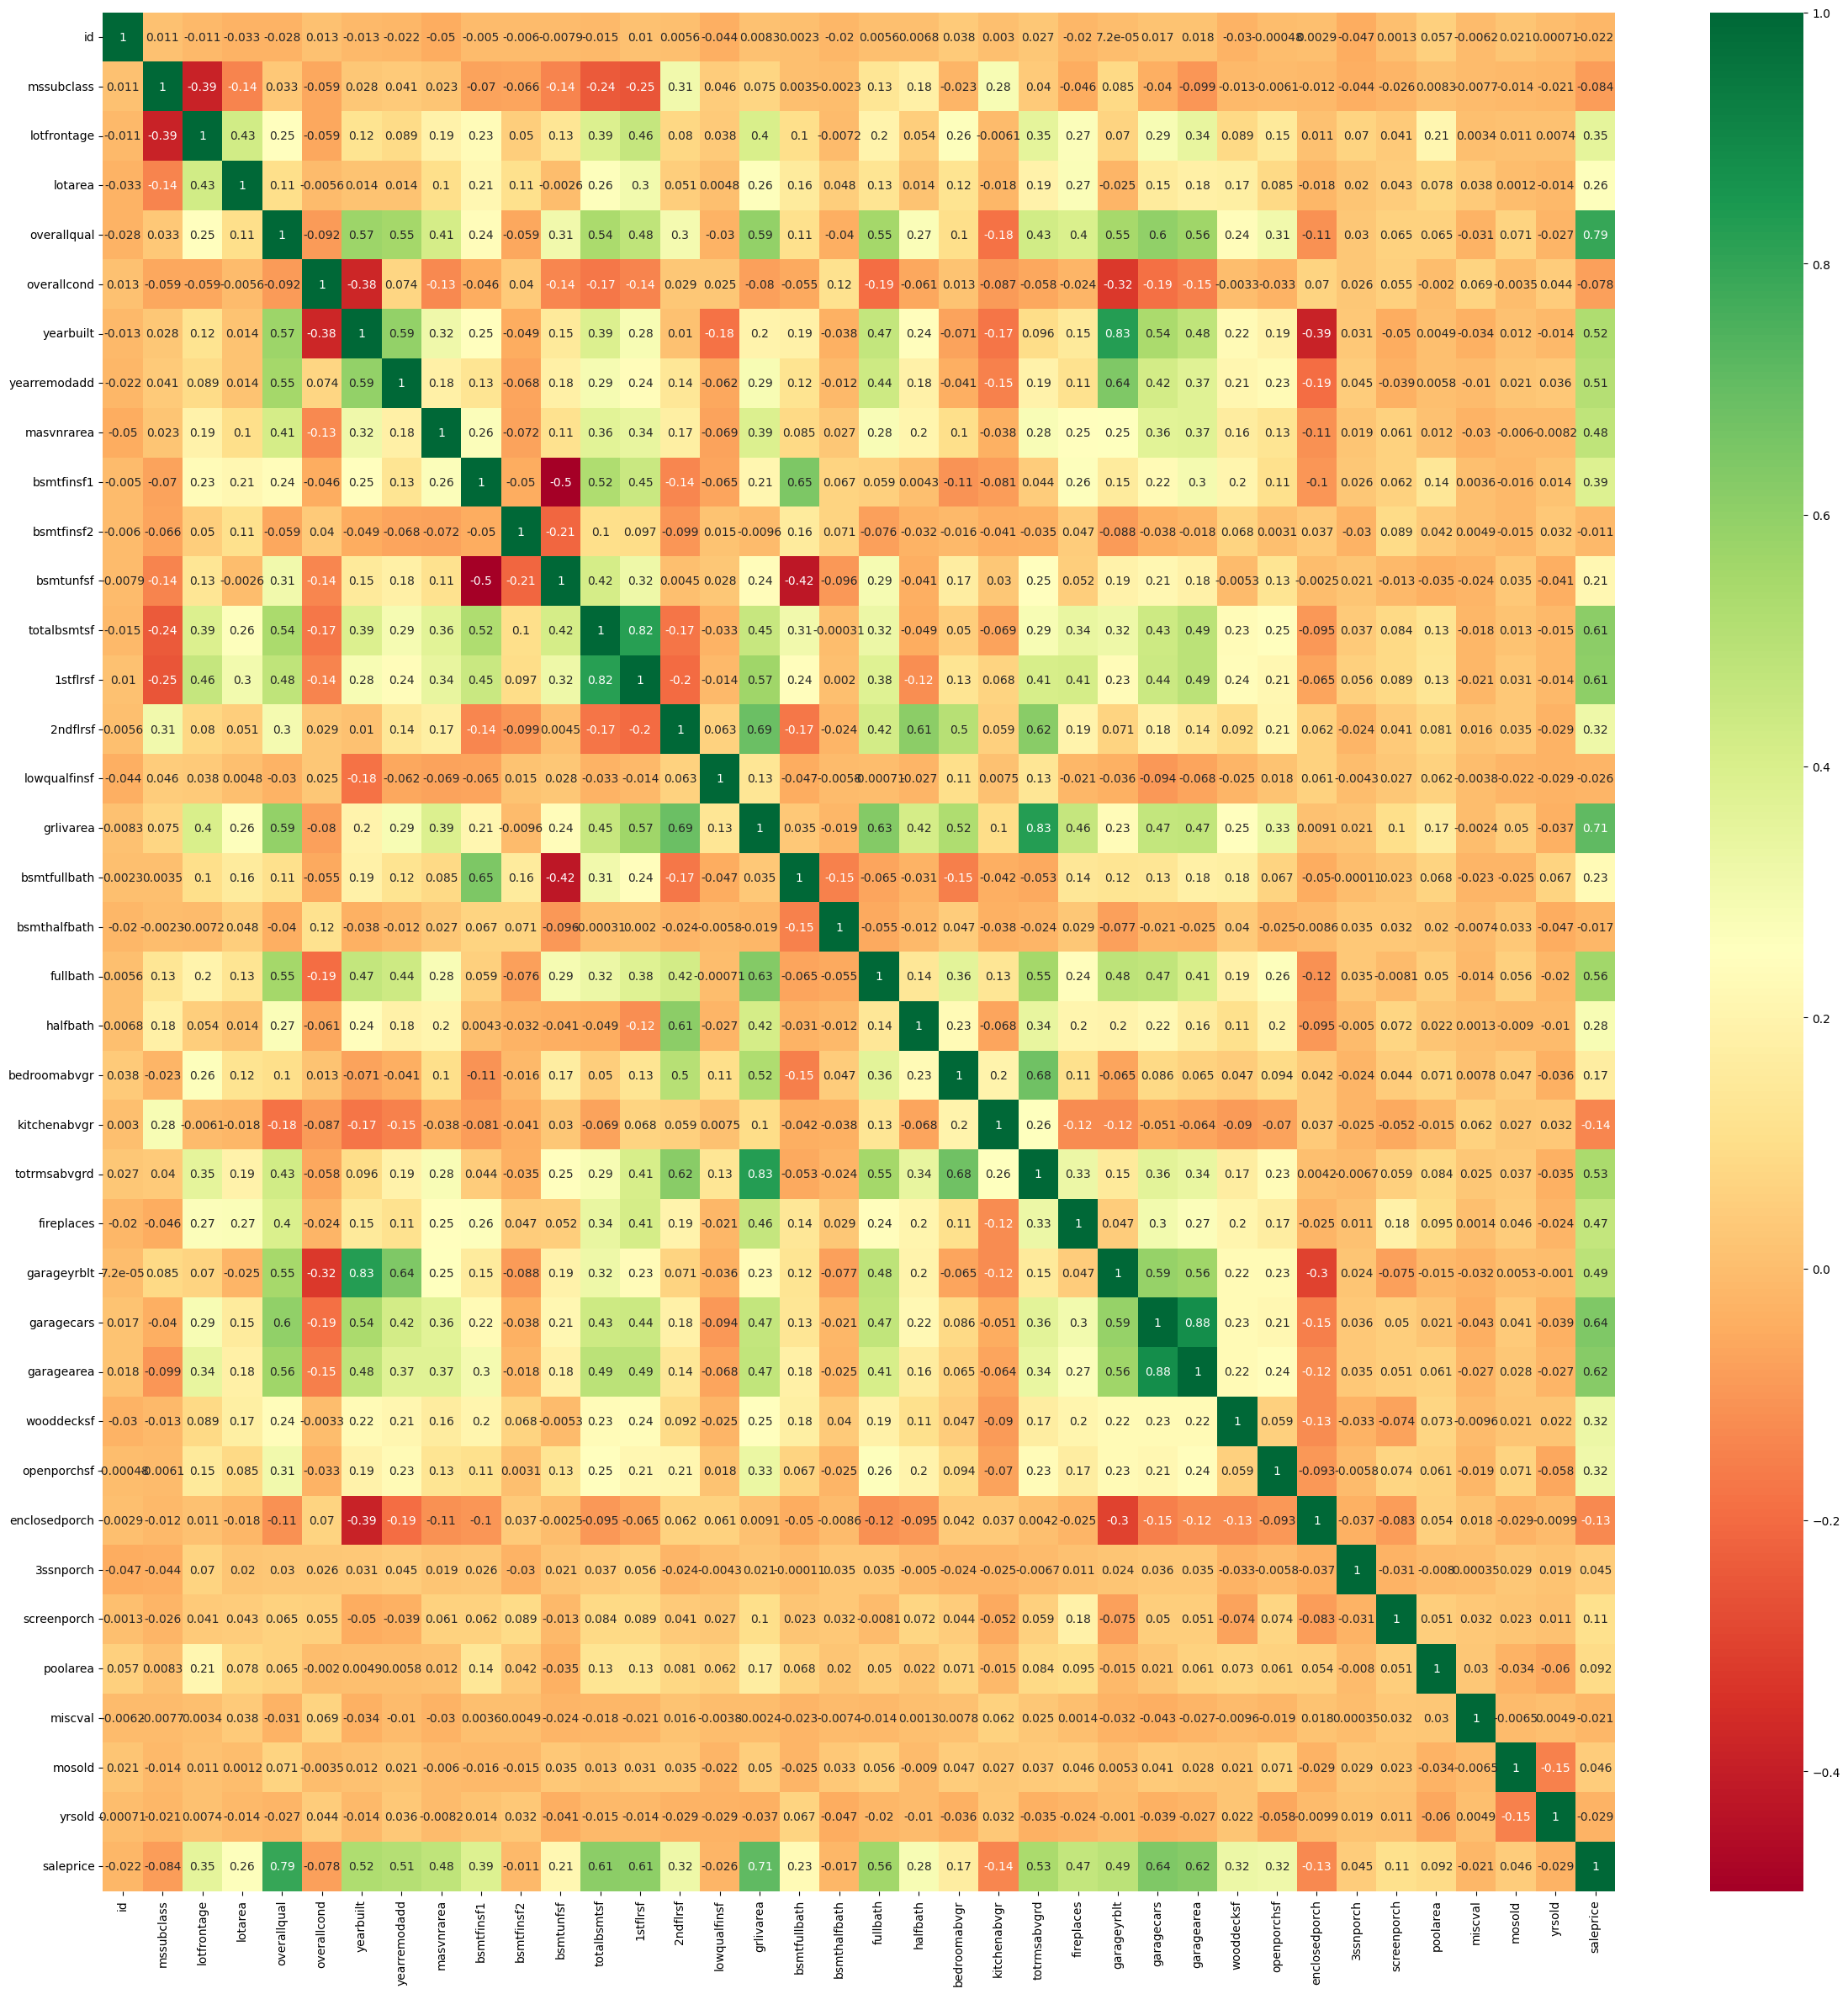

In [28]:
plt.figure(figsize=(29,29))
sns.heatmap(df_immo.corr(),annot=True,cmap='RdYlGn')
plt.show()

Certaines features comportent un trop grand nombre de valeurs manquantes : alley, fireplacequ, poolqc, fence et miscfeature. 

Dans un premier temps, nous allons juste supprimer ces colonnes bien que certaines valeurs peuvent être facilement remplacées afin d'entrainer notre modèle une première fois sans ces valeurs qui nous permettra d'obtenir un score 'temoin'. Ainsi nous pourrons verifier l'importance de ces features par la suite. 

Par la suite, nous remplacerons ces valeurs afin des les ajouter à notre modèle. Par exemple, pour  fireplacequ, nous avons 690 valeurs manquantes, un nombre important mais qui correspond en fait aux logements qui ne possèdent pas de cheminée, donc nous pourrions remplacer ces valeurs par 0 afin de rendre notre dataset plus complet. 

D'autant plus qu'il existe une forte corrélation entre la qualité d'une cheminée et le prix de vente d'une maison, donc cette valeur pourra nous être très utile par la suite. 

In [29]:
important_num = list(df_immo.corr()["saleprice"][(df_immo.corr()["saleprice"]>0.50) | (df_immo.corr()["saleprice"]<-0.50)].index)

print(important_num)

['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', '1stflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 'garagecars', 'garagearea', 'saleprice']


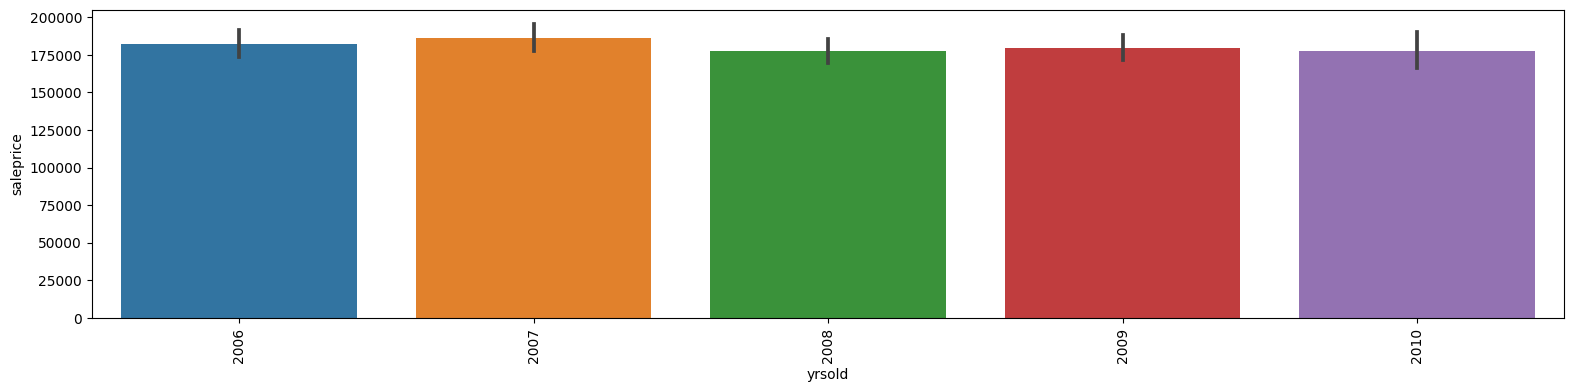

In [30]:
plt.subplots(figsize=(19, 4))
sns.barplot(x=df_immo['yrsold'], y=df_immo['saleprice'])
plt.xticks(rotation=90)
plt.show()

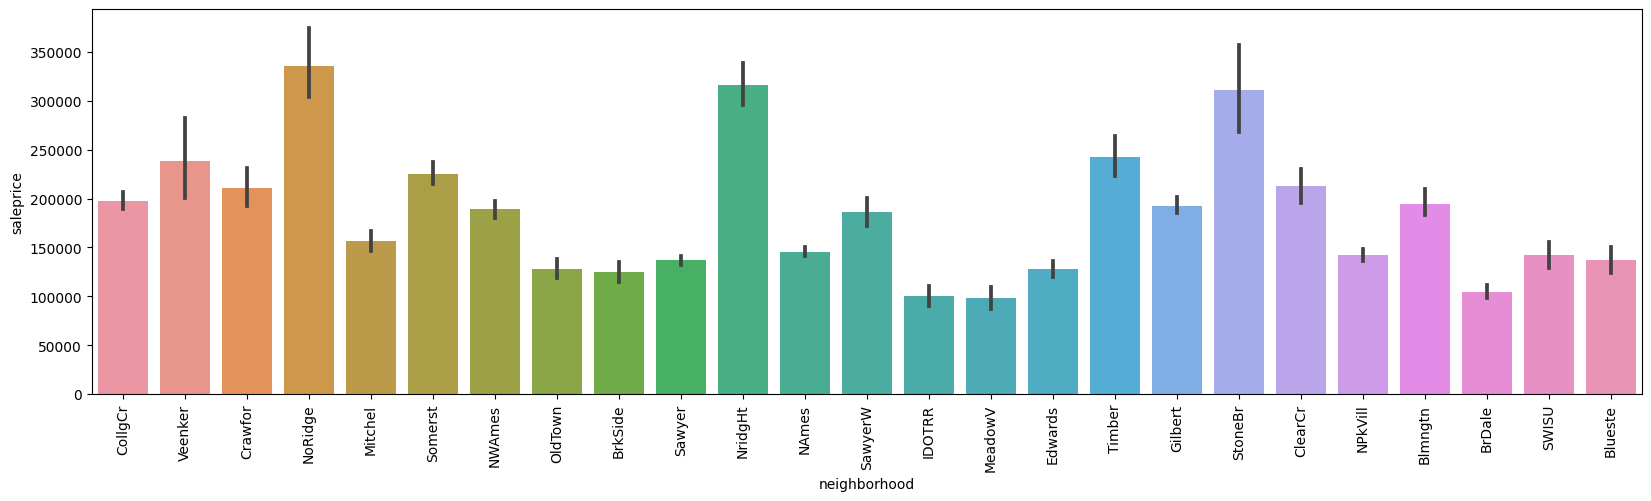

In [31]:
plt.subplots(figsize=(20,5))
sns.barplot(x=df_immo['neighborhood'], y=df_immo['saleprice'])
plt.xticks(rotation=90)
plt.show()

# Données avec valeurs nulles 

# fireplacequ

In [32]:
df_immo['fireplace'] = df_immo['fireplaces'].apply(lambda x : 1 if x > 0 else 0)
df_immo['fireplace'].value_counts()

1    770
0    690
Name: fireplace, dtype: int64

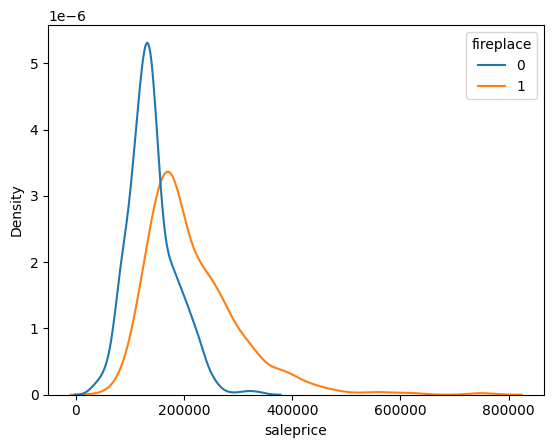

In [33]:
sns.kdeplot(data = df_immo, x = "saleprice" , hue ='fireplace')
plt.show()

In [34]:
df_immo['fireplacequ'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: fireplacequ, dtype: int64

Les maisons possédant une cheminée (ou plusieurs), on tendance à être plus cher que les autres. Reliée à la matrice de correlation, nous pouvons donc dire que cette donnée est determinante. De plus, nous pouvons voir que les valeurs NA ne sont pas reconnu dans notre dataframe, elles sont considérées comme des valeurs manquantes. 

In [35]:
## remplacement des valeurs nulles et encodage de la colonne 'fireplacequ'
def fire(row):
    if row['fireplacequ'] == 'Ex':
        return 5
    elif row['fireplacequ'] == 'Gd':
        return 4
    elif row['fireplacequ'] == 'TA':
        return 3   
    elif row['fireplacequ'] == 'Fa':
        return 2
    elif row['fireplacequ'] == 'Po':
        return 1
    else : 
        return 0

df_immo['fireplacequ'] = df_immo.apply(fire, axis = 1)
df_immo['fireplacequ'].head(5)

0    0
1    3
2    3
3    4
4    3
Name: fireplacequ, dtype: int64

### poolaera et poolqc

In [36]:
#creation d'une colonne qui donne la présnce ou non de cheminée.
df_immo['pool'] = df_immo['poolarea'].apply(lambda x : 1 if x > 0 else 0)
df_immo['pool'].value_counts()

0    1453
1       7
Name: pool, dtype: int64

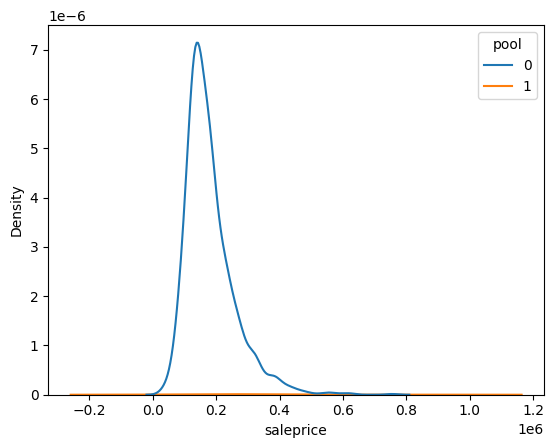

In [37]:
sns.kdeplot(data = df_immo, x = "saleprice" , hue ='pool')
plt.show()

In [38]:
df_immo.loc[df_immo['pool'] == 1][['saleprice','poolqc','poolarea']]

,saleprice,poolqc,poolarea
197,235000,Ex,512
810,181000,Fa,648
1170,171000,Gd,576
1182,745000,Ex,555
1298,160000,Gd,480
1386,250000,Fa,519
1423,274970,Gd,738


In [39]:
df_immo = df_immo.drop(['poolarea', 'poolqc', 'pool'], axis = 1)

Après avoir analysé les données en lien avec la piscine, on peut dire qu'il ne s'agit pas d'un élément important de la constitution du prix de vente d'une maison.

### Alley, Fence, Miscfeature

In [40]:
df_immo.groupby('alley', dropna=False).mean()['saleprice']

alley
Grvl    122219.080000
Pave    168000.585366
NaN     183452.131483
Name: saleprice, dtype: float64

In [41]:
df_immo.groupby('fence', dropna=False).mean()['saleprice']

fence
GdPrv    178927.457627
GdWo     140379.314815
MnPrv    148751.089172
MnWw     134286.363636
NaN      187596.837998
Name: saleprice, dtype: float64

In [42]:
df_immo.groupby('miscfeature', dropna=False).mean()['saleprice']

miscfeature
Gar2    170750.000000
Othr     94000.000000
Shed    151187.612245
TenC    250000.000000
NaN     182046.410384
Name: saleprice, dtype: float64

In [43]:
df_immo = df_immo.drop(['alley','miscfeature','fence'], axis = 1)

Pour ces différentes variables, il y a beaucoup trop de valeurs manquantes, d'autant que chacunes ne sont pas suffisament discriminantes pour être conservées.

### Lotfrontage

In [44]:
df_immo.groupby('lotfrontage', dropna=False).mean()['saleprice']

lotfrontage
21.0      94278.260870
24.0     145226.315789
30.0     160480.833333
32.0     186700.000000
33.0     113000.000000
             ...      
168.0    274725.000000
174.0    319000.000000
182.0    259000.000000
313.0    201000.000000
NaN      181620.073359
Name: saleprice, Length: 111, dtype: float64

In [45]:
df_immo['lotfrontage'] = df_immo['lotfrontage'].fillna(0)

### Masvnrtype // masvnarea

In [46]:
df_immo.groupby('masvnrtype', dropna=False).mean()['saleprice']

masvnrtype
BrkCmn     146318.066667
BrkFace    204691.871910
None       156221.891204
Stone      265583.625000
NaN        236484.250000
Name: saleprice, dtype: float64

In [47]:
df_immo.groupby('masvnrarea', dropna=False).mean()['saleprice']

masvnrarea
0.0       156557.946574
1.0       152250.000000
11.0      160200.000000
14.0      191000.000000
16.0      190233.571429
              ...      
1129.0    176000.000000
1170.0    755000.000000
1378.0    625000.000000
1600.0    239000.000000
NaN       236484.250000
Name: saleprice, Length: 328, dtype: float64

In [48]:
df_immo['masvnrtype'] = df_immo['masvnrtype'].fillna('NaN')
df_immo['masvnrarea'] = df_immo['masvnrarea'].fillna(0)

# bsmtqual, bsmtcond, bsmtexposure, bsmtfintype1, bsmtfintype2

In [49]:
df_immo.groupby('bsmtqual', dropna=False).mean()['saleprice']

bsmtqual
Ex     327041.041322
Fa     115692.028571
Gd     202688.478964
TA     140759.818182
NaN    105652.891892
Name: saleprice, dtype: float64

In [50]:
df_immo.groupby('bsmtcond', dropna=False).mean()['saleprice']

bsmtcond
Fa     121809.533333
Gd     213599.907692
Po      64000.000000
TA     183632.620900
NaN    105652.891892
Name: saleprice, dtype: float64

In [51]:
df_immo.groupby('bsmtexposure', dropna=False).mean()['saleprice']

bsmtexposure
Av     206643.420814
Gd     257689.805970
Mn     192789.657895
No     165652.295908
NaN    107938.342105
Name: saleprice, dtype: float64

In [52]:
df_immo.groupby('bsmtfintype1', dropna=False).mean()['saleprice']

bsmtfintype1
ALQ    161573.068182
BLQ    149493.655405
GLQ    235413.720096
LwQ    151852.702703
Rec    146889.248120
Unf    170670.576744
NaN    105652.891892
Name: saleprice, dtype: float64

In [53]:
df_immo.groupby('bsmtfintype2', dropna=False).mean()['saleprice']

bsmtfintype2
ALQ    209942.105263
BLQ    151101.000000
GLQ    180982.142857
LwQ    164364.130435
Rec    164917.129630
Unf    184694.690287
NaN    110346.236842
Name: saleprice, dtype: float64

In [54]:
df_immo['bsmtqual'] = df_immo['bsmtqual'].fillna('NaN')
df_immo['bsmtcond'] = df_immo['bsmtcond'].fillna('NaN')
df_immo['bsmtexposure'] = df_immo['bsmtexposure'].fillna('NaN')
df_immo['bsmtfintype1'] = df_immo['bsmtfintype1'].fillna('NaN')
df_immo['bsmtfintype2'] = df_immo['bsmtfintype2'].fillna('NaN')

### garagetype, garageyrblt, garagequal, garagecond, garagefinish

In [55]:
df_immo.groupby('garagetype', dropna=False).mean()['saleprice']

garagetype
2Types     151283.333333
Attchd     202892.656322
Basment    160570.684211
BuiltIn    254751.738636
CarPort    109962.111111
Detchd     134091.162791
NaN        103317.283951
Name: saleprice, dtype: float64

In [56]:
df_immo.groupby('garageyrblt', dropna=False).mean()['saleprice']

garageyrblt
1900.0    133900.000000
1906.0    135000.000000
1908.0    240000.000000
1910.0    125000.000000
1914.0    150943.500000
              ...      
2007.0    240372.836735
2008.0    306569.034483
2009.0    306111.000000
2010.0    337874.666667
NaN       103317.283951
Name: saleprice, Length: 98, dtype: float64

In [57]:
df_immo.groupby('garagefinish', dropna=False).mean()['saleprice']

garagefinish
Fin    240052.690341
RFn    202068.869668
Unf    142156.423140
NaN    103317.283951
Name: saleprice, dtype: float64

In [58]:
df_immo.groupby('garagequal', dropna=False).mean()['saleprice']

garagequal
Ex     241000.000000
Fa     123573.354167
Gd     215860.714286
Po     100166.666667
TA     187489.836003
NaN    103317.283951
Name: saleprice, dtype: float64

In [59]:
df_immo.groupby('garagecond', dropna=False).mean()['saleprice']

garagecond
Ex     124000.000000
Fa     114654.028571
Gd     179930.000000
Po     108500.000000
TA     187885.735294
NaN    103317.283951
Name: saleprice, dtype: float64

In [60]:
df_immo['garagetype'] = df_immo['garagetype'].fillna('NaN')
df_immo['garageyrblt'] = df_immo['garageyrblt'].fillna(0)
df_immo['garagefinish'] = df_immo['garagefinish'].fillna('NaN')
df_immo['garagequal'] = df_immo['garagequal'].fillna('NaN')
df_immo['garagecond'] = df_immo['garagecond'].fillna('NaN')

In [61]:
features_with_na=[features for features in df_immo.columns if df_immo[features].isnull().sum()>1]

for feature in features_with_na:
    print(f'{feature:-<30} : {np.round(df_immo[feature].isnull().sum(),4)}')
nombre_ligne = 'TOTAL LIGNE'
print(f'{nombre_ligne:-<30} : {len(df_immo.id)}')

TOTAL LIGNE------------------- : 1460


J'ai terminé de remplacer les valeurs manquantes dans mon dataframe, en remplaçant les valeurs soit par leur valeur de base qui n'était pas prise en compte dans le tableau, soit par la moyenne pour les valeurs numériques. Pour les colonnes : 'alley','miscfeature','fence', 'poolaera' et 'poolqc', j'ai préféré les supprimer, car leur trop grand nombre de valeurs manquantes peut être un problème pour la suite, et je ne peux pas prendre le risque de les remplacer hasardeusement, au risque de trop influer sur mon jeu de donné. Nous pourrons par la suite choisir de les réintégrer pour essayer d'affiner notre score.

In [62]:
def encodage(row):
    taille = [x for x in range(0, len(df_immo_encod[row].unique()))]
    valeur_encode = df_immo_encod[row].unique()
    result = dict(zip(valeur_encode, taille))

    df_immo_encod[row] = df_immo_encod[row].map(result)

df_immo_encod = df_immo.copy()
for i in df_immo_encod.columns:
    if type(df_immo_encod[i][0]) == str:
        encodage(i)

In [63]:
df_immo.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,enclosedporch,3ssnporch,screenporch,miscval,mosold,yrsold,saletype,salecondition,saleprice,fireplace
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,2,2006,WD,Abnorml,140000,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000,1


In [64]:
df_immo_encod.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,enclosedporch,3ssnporch,screenporch,miscval,mosold,yrsold,saletype,salecondition,saleprice,fireplace
0,1,60,0,65.0,8450,0,0,0,0,0,...,0,0,0,0,2,2008,0,0,208500,0
1,2,20,0,80.0,9600,0,0,0,0,1,...,0,0,0,0,5,2007,0,0,181500,1
2,3,60,0,68.0,11250,0,1,0,0,0,...,0,0,0,0,9,2008,0,0,223500,1
3,4,70,0,60.0,9550,0,1,0,0,2,...,272,0,0,0,2,2006,0,1,140000,1
4,5,60,0,84.0,14260,0,1,0,0,1,...,0,0,0,0,12,2008,0,0,250000,1


In [65]:
correlation = []
for item in df_immo_encod.columns:
    correlation.append((df_immo_encod[item].corr(df_immo_encod['saleprice'])))

In [66]:
columns_names = df_immo_encod.columns.tolist()
correlation_list_df = pd.DataFrame({'column': columns_names,'correlation': correlation })

correlation_list_df = correlation_list_df.sort_values(by='correlation', ascending=False)
print(correlation_list_df)

          column  correlation
75     saleprice     1.000000
16   overallqual     0.790982
45     grlivarea     0.708624
60    garagecars     0.640409
61    garagearea     0.623431
..           ...          ...
57    garagetype    -0.255560
26     exterqual    -0.265015
32  bsmtfintype1    -0.370971
39     heatingqc    -0.427649
28    foundation    -0.429678

[77 rows x 2 columns]


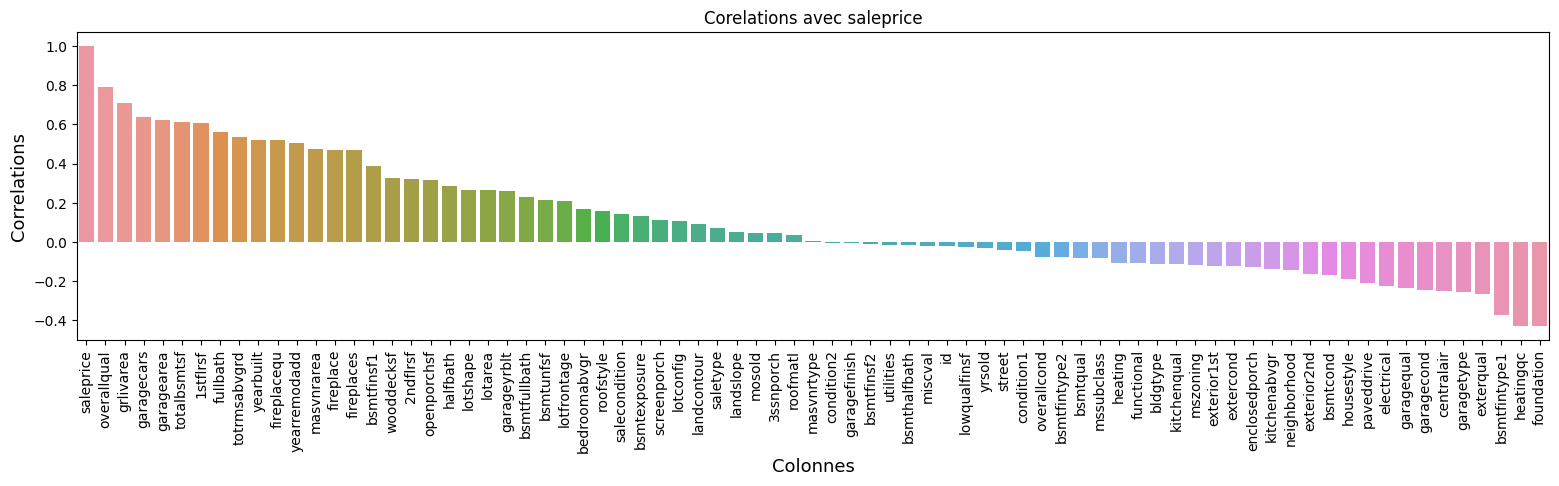

In [67]:
plt.subplots(figsize=(19, 4))
sns.barplot(x=correlation_list_df['column'], y=correlation_list_df['correlation'])
plt.xticks(rotation=90)
plt.ylabel('Correlations', fontsize=13)
plt.xlabel('Colonnes', fontsize=13)
plt.title('Corelations avec saleprice')
plt.show()

Plus explicite que la matrice de correlation, ce graphique nous permet de voir les correlations de chaque features grâce à l'encodage brute utilisé sur les valeurs non numériques.

# Pipelines

In [68]:
X = df_immo_encod.drop('saleprice', axis =1)
y = df_immo_encod['saleprice']

df_immo_encod.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,enclosedporch,3ssnporch,screenporch,miscval,mosold,yrsold,saletype,salecondition,saleprice,fireplace
0,1,60,0,65.0,8450,0,0,0,0,0,...,0,0,0,0,2,2008,0,0,208500,0
1,2,20,0,80.0,9600,0,0,0,0,1,...,0,0,0,0,5,2007,0,0,181500,1
2,3,60,0,68.0,11250,0,1,0,0,0,...,0,0,0,0,9,2008,0,0,223500,1
3,4,70,0,60.0,9550,0,1,0,0,2,...,272,0,0,0,2,2006,0,1,140000,1
4,5,60,0,84.0,14260,0,1,0,0,1,...,0,0,0,0,12,2008,0,0,250000,1


In [69]:
numerical_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(StandardScaler())

preprocessor = make_column_transformer((numerical_pipeline, numerical_features))

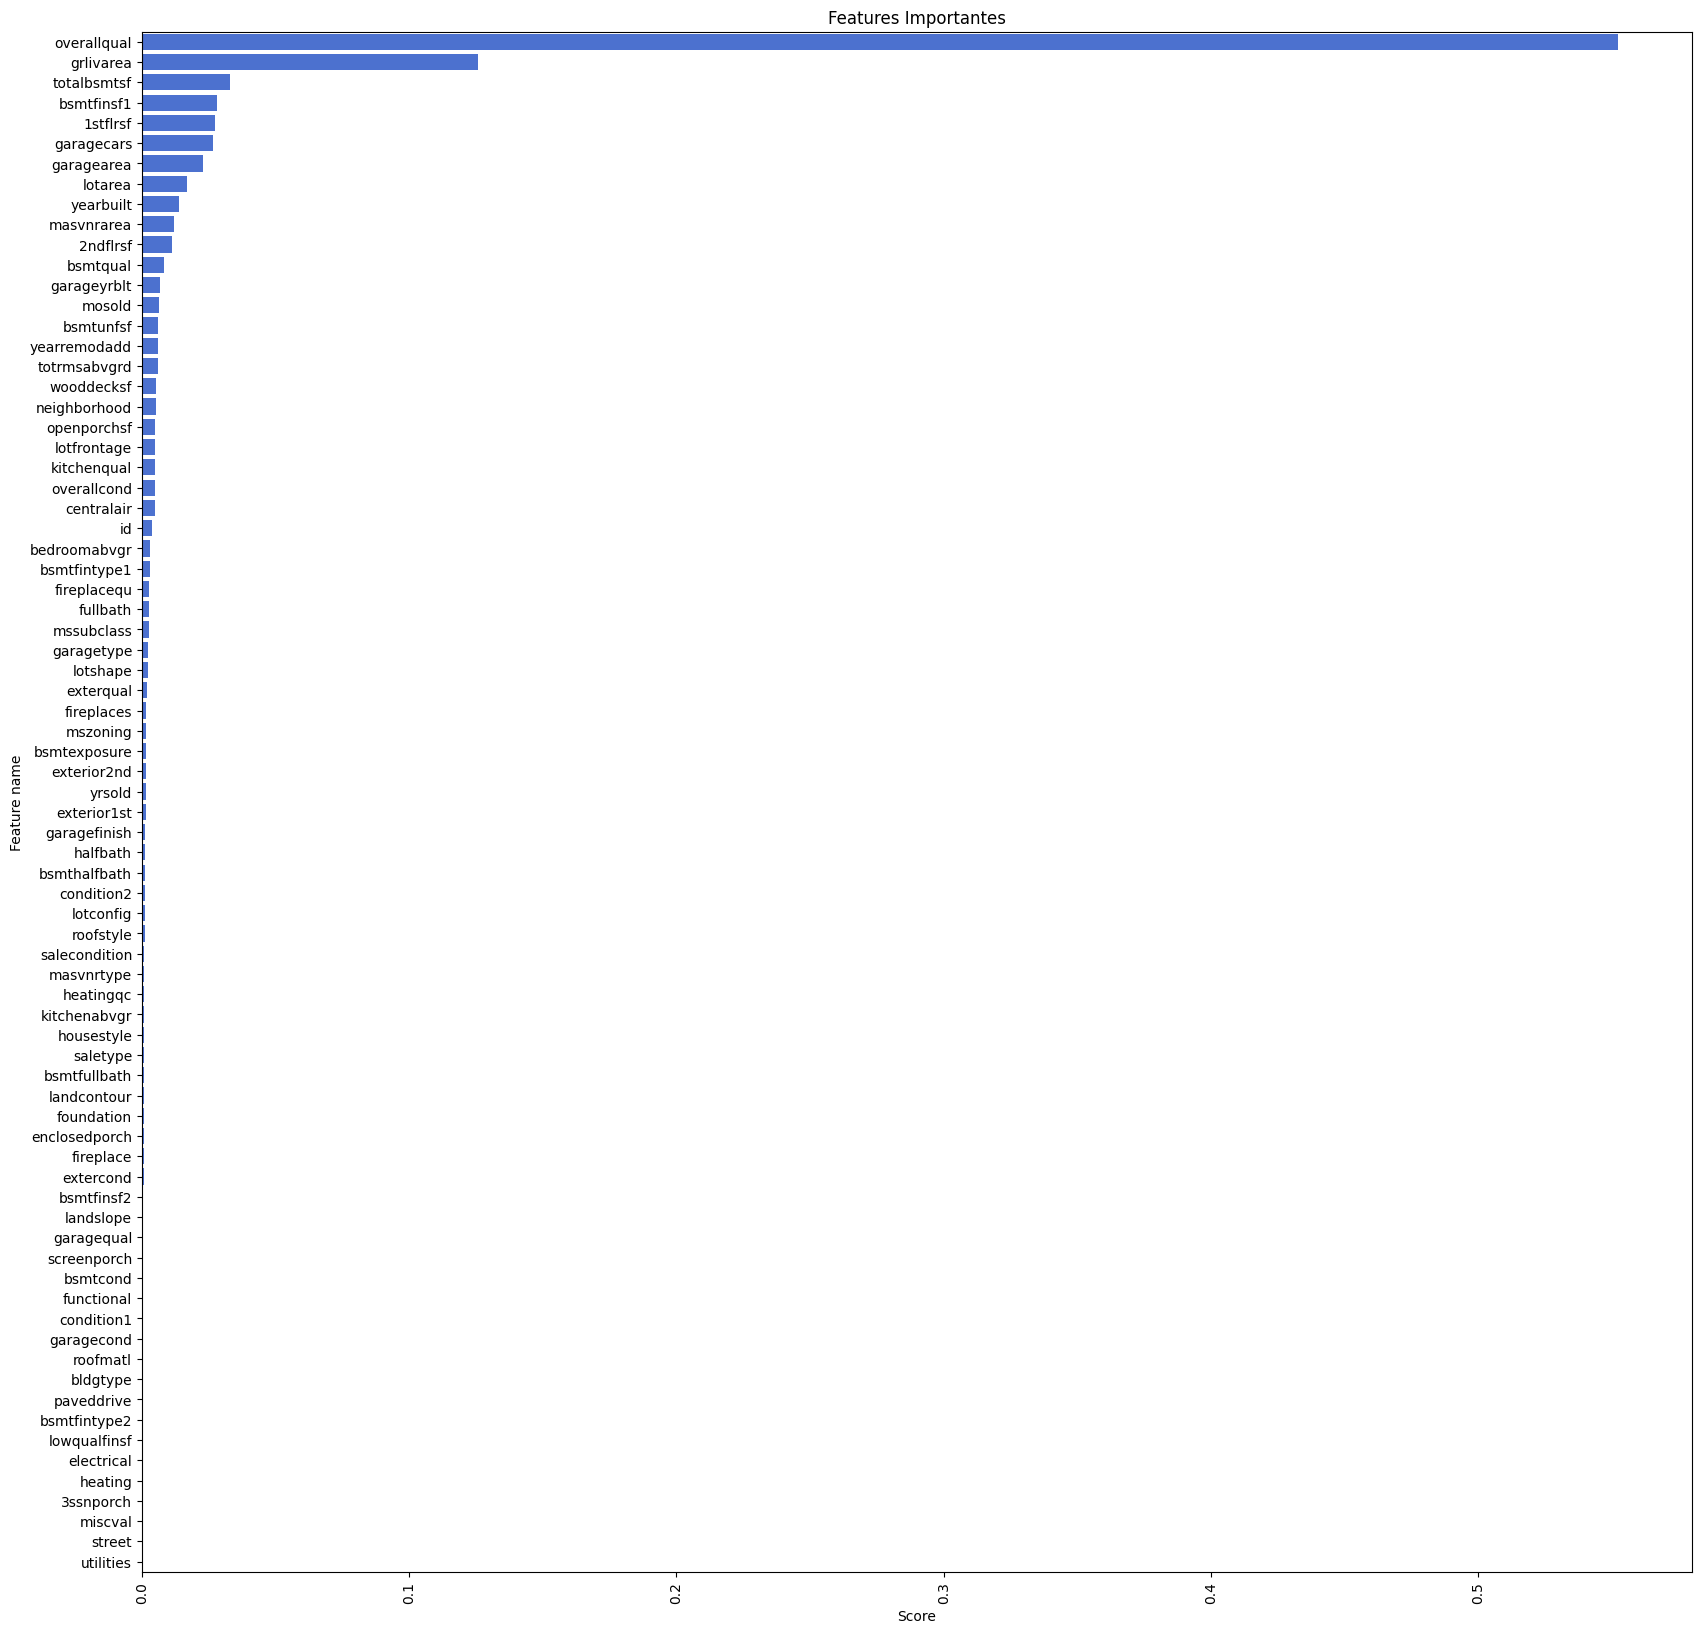

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ftr_imp = pd.Series(model.feature_importances_, index = X_train.columns)
ftr_imp.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(20, 20))

sns.barplot(x=ftr_imp.tolist(), y=ftr_imp.index, color="#0343DF", alpha=0.8)
plt.title("Features Importantes")
plt.xticks(rotation=90)
plt.xlabel("Score")
plt.ylabel("Feature name")

plt.show()




In [71]:
print(important_num)

['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf', '1stflrsf', 'grlivarea', 'fullbath', 'totrmsabvgrd', 'garagecars', 'garagearea', 'saleprice']


Ce grapique représente la pertinence de chaque features pour le modèle RandomForestRegressor, les 10 principales features sont 'overallqual', 'grlivarea', 'totalbsmtsf','bsmtfinsf1', '1stflrst', 'garagecars', 'garagearea', 'lotarea', 'yearbuilt', 'masvnrarea' elles nous serviront plus tard en la regroupant avec la liste des features numériques qui ont la plus forte corrélation avec le prix.,

In [72]:
def train_function(X, y, preprocessor):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

    algo_list = [
        ('sgd', SGDRegressor(random_state=0)),
        ('gbr', GradientBoostingRegressor(random_state=0)),
        ('knn', KNeighborsRegressor()),
        ('svr', LinearSVR(random_state=0)),
        ('rf', RandomForestRegressor(random_state=0)), 
    ]

    list_mae = list()
    list_rmse = list()
    list_median = list()
    list_r2 = list()

    for algo in algo_list:
        model = make_pipeline(preprocessor, algo[1])
        model.fit(X_train,y_train)

        y_pred = model.predict(X_test)

        metrics = ['MAE', 'RMSE', 'Median abs err', 'R2']
        
        mae_metric = mean_absolute_error(y_test, y_pred)
        rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred))
        median_metric = median_absolute_error(y_test, y_pred)
        R2_metric = model.score(X_train,y_train)

        list_mae.append(mae_metric)
        list_rmse.append(rmse_metric)
        list_median.append(median_metric)
        list_r2.append(R2_metric)
        
        
        print('_'*60)
        print(f'{algo[0]}')
        print(f'{metrics[0]:-<20} : {mae_metric}')
        print(f'{metrics[1]:-<20} : {rmse_metric}')
        print(f'{metrics[2]:-<20} : {median_metric}')
        print(f'{metrics[3]:-<20} : {R2_metric}')
        print('_'*60)

        err_hist = np.abs(y_test - y_pred)
        plt.hist(err_hist, bins = 50)
        plt.title(algo[0])
        plt.show()

        train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.1, 1, 10))
        plt.plot(train_sizes,np.mean(train_scores, axis = 1), label = 'Train')
        plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Validation')
        plt.title('Learning-Curve')
        plt.legend()
        plt.show()  

    

    score_algo = pd.DataFrame({
        'Name' : [e[0] for e in algo_list],
        'MAE' : list_mae,
        'RMSE' : list_rmse,
        'Median abs err' : list_median,
        'R2' : list_r2, 
    })
    print(score_algo)
    

____________________________________________________________
sgd
MAE----------------- : 22109.978465352233
RMSE---------------- : 43935.67670712336
Median abs err------ : 14256.934561827744
R2------------------ : 0.8762815086904595
____________________________________________________________


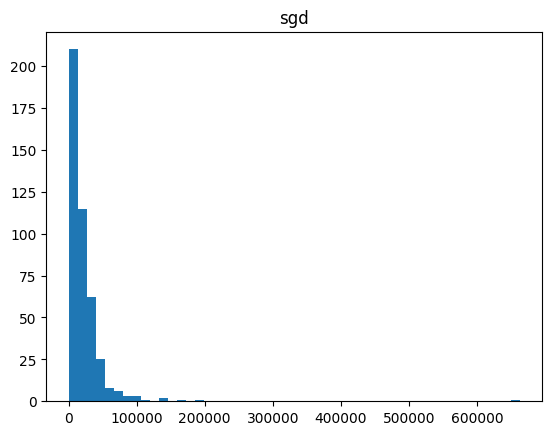

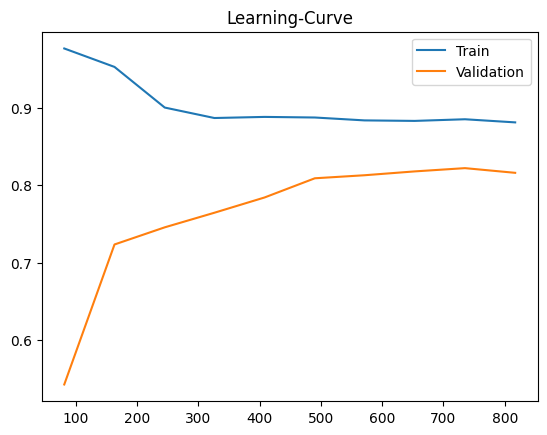

____________________________________________________________
gbr
MAE----------------- : 17530.50713310892
RMSE---------------- : 31233.804583736157
Median abs err------ : 10950.080815730165
R2------------------ : 0.9720860042800175
____________________________________________________________


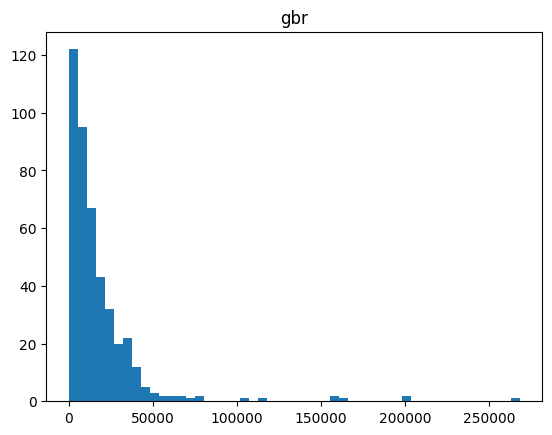

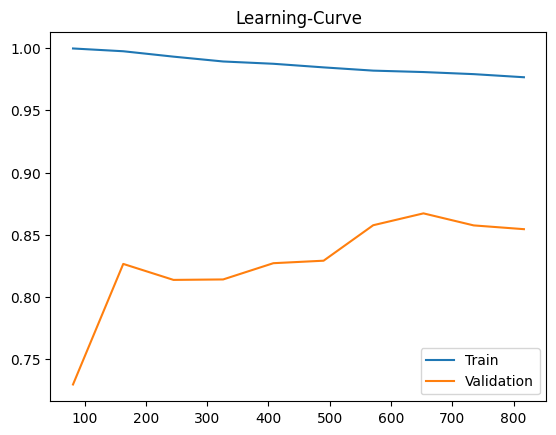

____________________________________________________________
knn
MAE----------------- : 24160.677625570777
RMSE---------------- : 40510.66406811464
Median abs err------ : 15529.5
R2------------------ : 0.8497512697529552
____________________________________________________________


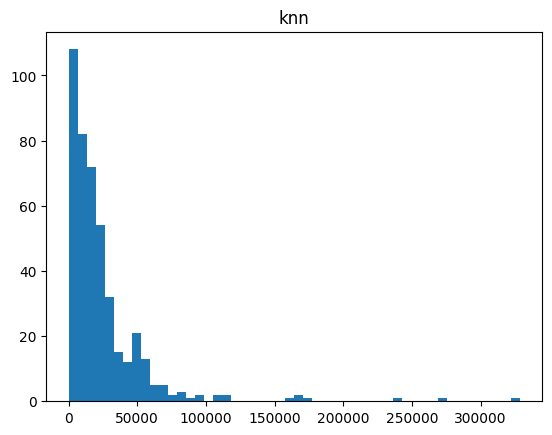

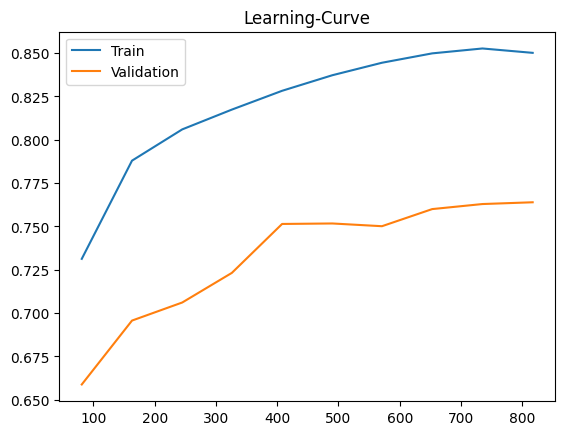

____________________________________________________________
svr
MAE----------------- : 180680.78538812784
RMSE---------------- : 198581.3124375851
Median abs err------ : 162678.0
R2------------------ : -5.286000164149694
____________________________________________________________


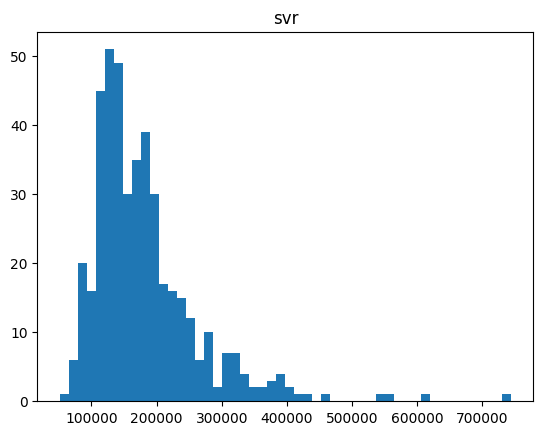

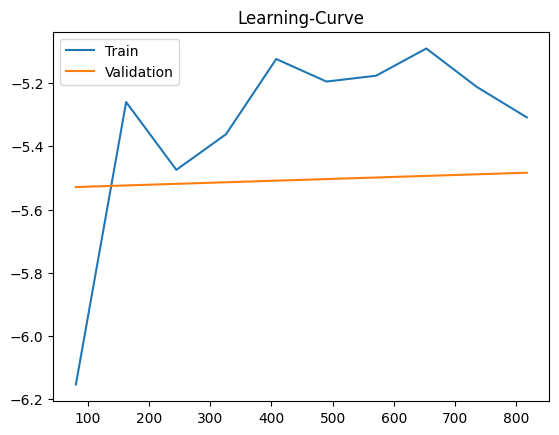

____________________________________________________________
rf
MAE----------------- : 17792.51420091324
RMSE---------------- : 32424.380461597266
Median abs err------ : 10192.849999999999
R2------------------ : 0.9784155133729183
____________________________________________________________


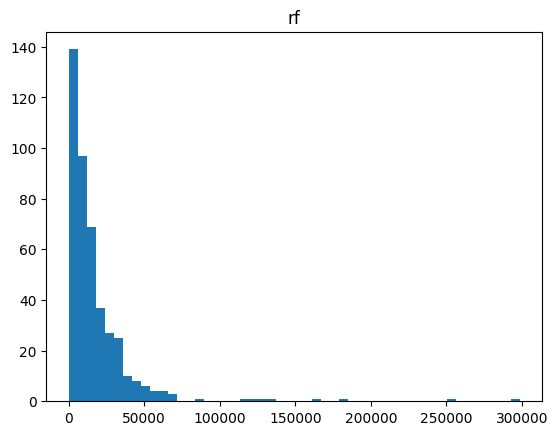

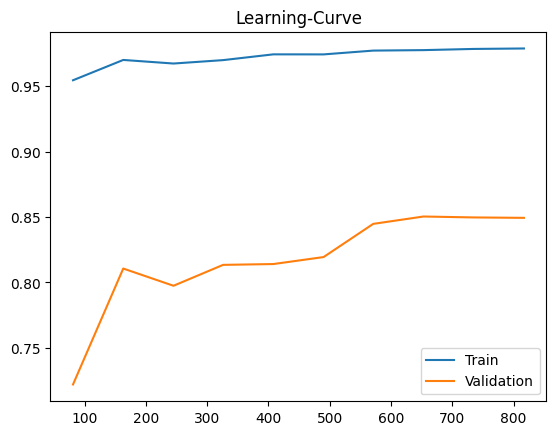

  Name            MAE           RMSE  Median abs err        R2
0  sgd   22109.978465   43935.676707    14256.934562  0.876282
1  gbr   17530.507133   31233.804584    10950.080816  0.972086
2  knn   24160.677626   40510.664068    15529.500000  0.849751
3  svr  180680.785388  198581.312438   162678.000000 -5.286000
4   rf   17792.514201   32424.380462    10192.850000  0.978416


In [73]:
train_function(X, y, preprocessor)

Ce premier entrainement d'algoryhme nous servira de résultat témoin afin de voir si les modifications que nous allons faire par la suite aurnont des conséquences positives sur nos futures prédicitons. Dans un premier temps, nous allons interpréter les données de chaque algorythme. 

### SGDRegressor :
Pour SGDRegressor, la MAE est de 22109. L'algorythme se trompe donc de 22109$ en moyenne. Par contre, si on prends le RMSE, plus sensible aux outliers, on peut voir que les erreurs sont bien plus importantes. C'est une chose que l'on peut affirmer en comparant la MAE avec le 'median abs err', puisque qu'en realité 50% des erreurs se trouve en dessous de 14256$.  
Et enfin le score R2, proche de 0.88 donc de 1, un score R2 élévé révèle la bonne performance d'un modèle.   
De plus sur la learning curve, nous pouvons voir que le modèle a tendance à ce stabiliséautour de 0.88.

### KNN :  
Pour le cas de Knn, le MAE est plus élévé que pour les deux modèles précédents, cependant le RMSE est moins élévé. Ce qui signifie que ce modèle est moins sensible au outliers. Il sera privilégier si nous voulons miniser les grandes erreurs. Le median est légérement plus élévée. Et le score est R2 est plus proche de 0.85, ce qui signifie que ce modèle reste quand même performant.  
Sur la learning curve, nous pouvons voir que le modèle continue de progresser légèrement, il pourrait peut être être plus performant avec plus de valeur. 

### SVR : 
Il est le modèle le moins performant pour cette exemple. Ca MAE est très grande, de même pour sa RMSE et son score median. Et son score R2 de -5, indique que ce modèle n'est pas du tout approprié pour cette exercice.  
Avec la learning curve, nous pouvons voir que le modèle ne progresse pas du tout bien que les données d'entrainement augmentent.
 
### RandomForest :
Il est le modèle le plus performant, avec un score R2 de presque 0.98. 50% de ces erreurs se trouvent sous les 10192$ et sa MAE est de 17792, cependant il reste sensible aux outliers avec un RMSE de 32424.  
Enfin, avec sa learning curve, on peut voir que le modèle n'est pas en overfiting, et qu'il se stabilise aux alentours de 0.85.

### Gbr
Commentaires similaires a ceux de RandomForest 